# Preprocessing BedMachine Topography and OIB Gravity Data

In [1]:
import verde as vd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import harmonica as hm
import cmocean
import os
import matplotlib.colors as colors
from tqdm.auto import tqdm
import sys

# Import custom fuctions
sys.path.append('../')
from bouguer import *

## BedMachine

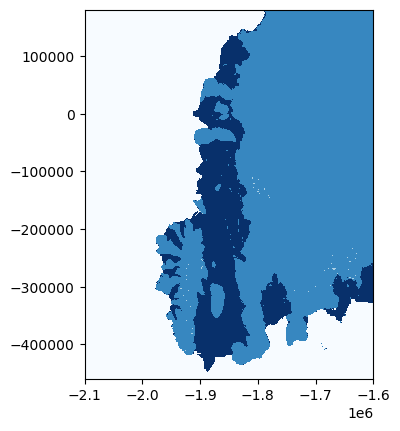

In [2]:
# BedMachine V3 downloaded from https://nsidc.org/data/nsidc-0756/versions/3
bm = xr.open_dataset('../raw_data/BedMachine/BedMachineAntarctica-v3.nc')

xcenter = -1850000
ycenter = -140000
xmargin = 500 * 500
ymargin = 500 * 640

# Trim to area around Abbot, Venable, Cosgrove ice shelves
ds = bm.sel(x = slice(xcenter - xmargin, xcenter + xmargin), y = slice(ycenter + ymargin, ycenter - ymargin))

# Check extent
plt.pcolormesh(ds['mask'].x.values, ds['mask'].y.values, ds['mask'].values, cmap='Blues')
# Ensure x-axis and y-axis have consistent spacing
plt.gca().set_aspect('equal')

In [ ]:
# Coarsen data from 500m resolution to 4km resolution
ds = ds.coarsen(x=8, y=8, boundary='trim', coord_func='median').median()

# ensure mask includes all integers by rounding any non-integer values after taking the median
ds['mask'] = ds['mask'].round(decimals = 0)

# make sure surface is 0 in open water
ds['surface'] = (('y', 'x'), np.where(ds.mask==0, 0, ds.surface))

# make sure thickness is 0 in open water and at exposed rock
ocean_rock_msk = (ds.mask==0)^(ds.mask==1)
ds['thickness'] = (('y', 'x'), np.where(ocean_rock_msk, 0, ds.thickness))

# make sure bed is equal to surface minus thickness under grounded ice
ds['bed'] = (('y', 'x'), np.where(ds.mask==2, ds.surface-ds.thickness, ds.bed))

# make sure surface is equal to bed at exposed rock
ds['bed'] = (('y', 'x'), np.where(ds.mask==1, ds.surface, ds.bed))

# make sure bed not above ice in ice shelf
bed_above_ice_bottom = np.where(ds.bed > (ds.surface-ds.thickness), True, False)
ds['bed'] = (('y', 'x'), np.where(bed_above_ice_bottom, ds.surface-ds.thickness, ds.bed))

# make mask grounded ice where bed was above ice bottom
ds['mask'] = (('y', 'x'), np.where(bed_above_ice_bottom, 2, ds.mask))

# reference elevations to WGS84
ds['bed'] += ds['geoid']
ds['surface'] += ds['geoid']

In [ ]:
# create inversion mask where ice shelves are
ds['inv_msk'] = xr.where(ds.mask == 3, True, False)

# store resolution as attribute
ds = ds.assign_attrs({'res' : int(np.abs(ds.x.values[1] - ds.x.values[0]))})

print(f'Resolution: {ds.res} meters')

Resolution: 4000 meters


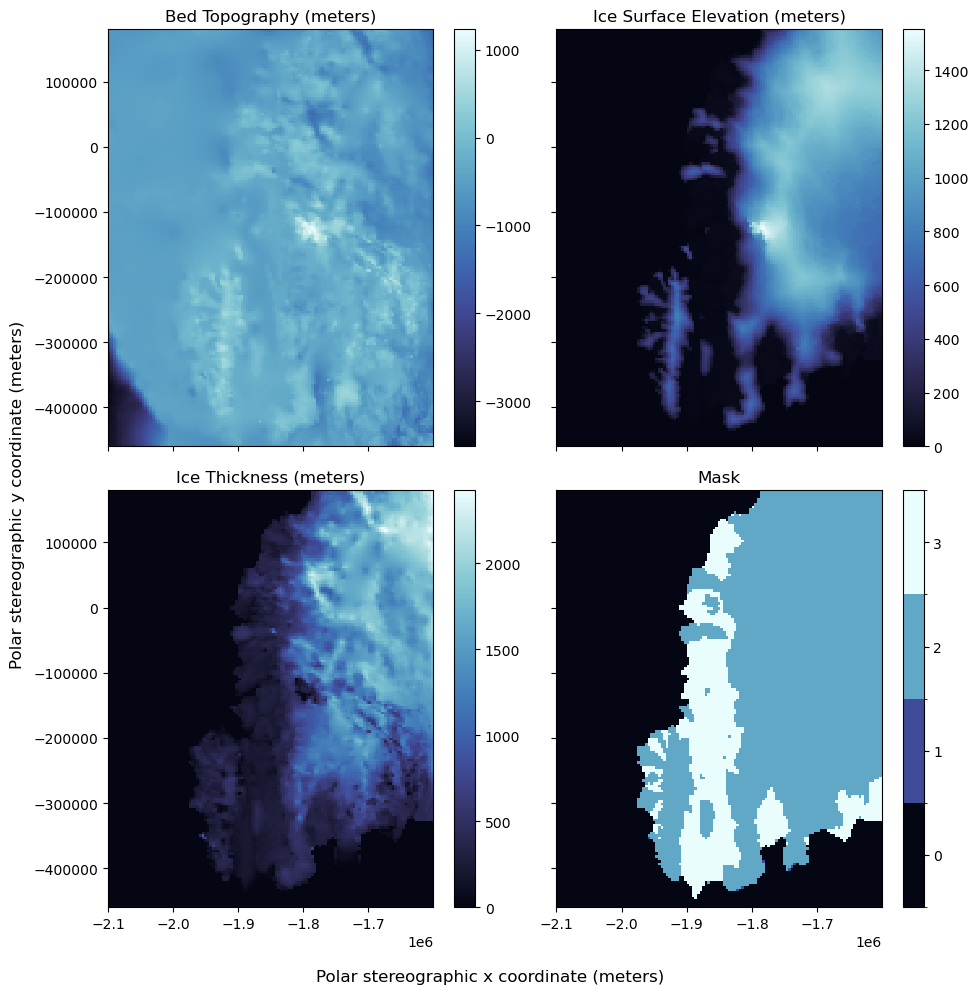

In [5]:
def plot_bedmachine(data, variables):
    """Given an xarray DataArray of BedMachine V3 data and list of variables,
    plot the variables (bed, surface, thickness, and mask)"""
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,10))

    # Loop through each variable and create a subplot
    for id, var, name in zip([(0,0),(0,1),(1,0),(1,1)], variables, ['Bed Topography', 'Ice Surface Elevation', 'Ice Thickness', 'Mask']):
        cmap = cmocean.cm.ice
        if var == "mask": # Assign discrete colormap for mask
            plot = axs[id].pcolormesh(data[var].x.values, data[var].y.values, data[var].values, cmap=cmap,
                                                norm = colors.BoundaryNorm([0,1,2,3,4], cmap.N))
            cbar = plt.colorbar(plot)
            cbar.set_ticks([0.5,1.5,2.5,3.5])
            cbar.set_ticklabels([0,1,2,3])
            title = name
        else:
            plot = axs[id].pcolormesh(data[var].x.values, data[var].y.values, data[var].values, cmap=cmap)
            plt.colorbar(plot)
            # Add units to title
            title = name + " (meters)"
        axs[id].set_title(title)
        
        # Ensure x-axis and y-axis have consistent spacing
        axs[id].set_aspect('equal')

    # Create shared x and y label for all plots
    fig.supxlabel("Polar stereographic x coordinate (meters)")
    fig.supylabel("Polar stereographic y coordinate (meters)")

    plt.tight_layout()

plot_bedmachine(ds, ['bed', 'surface', 'thickness', 'mask'])

In [44]:
# Create encoding dictionary to match encoding of the dataset read from BedMachine
encoding = {}
encoding_keys = ("_FillValue", "dtype", "scale_factor", "add_offset", "grid_mapping")
for data_var in bm.data_vars:
    encoding[data_var] = {key: value for key, value in bm[data_var].encoding.items() if key in encoding_keys}

encoding

{'mapping': {'dtype': dtype('S1')},
 'mask': {'dtype': dtype('int8')},
 'firn': {'dtype': dtype('float32')},
 'surface': {'dtype': dtype('float32')},
 'thickness': {'dtype': dtype('float32')},
 'bed': {'dtype': dtype('float32'), '_FillValue': np.float32(-9999.0)},
 'errbed': {'dtype': dtype('int16'), '_FillValue': np.int16(-9999)},
 'source': {'dtype': dtype('int8')},
 'dataid': {'dtype': dtype('int8')},
 'geoid': {'dtype': dtype('int16')}}

In [ ]:
# Export trimmed and coarsened data to NetCDF
ds.to_netcdf(f"processed_data/xr_{ds.res}.nc", format='NETCDF4', encoding=encoding)

## OIB Gravity

In [ ]:
# Get number of grav folders for tqdm
num_folders = 0
for folder in os.scandir('../raw_data/OIB_Sander'):
    num_folders += 1

# Iterate through folders and ingest data
tables = []
for folder in tqdm(os.scandir('../raw_data/OIB_Sander'), total=num_folders):
    for item in os.scandir(folder.path):
        if item.name.endswith('.txt'):
            tmp = pd.read_table(item.path, header=69, sep='\s+')
            header = tmp.columns[1:]
            tmp = tmp.drop(columns=['FLTENVIRO'])
            tmp.columns = header
            tables.append(tmp)

grav = pd.concat(tables, axis=0)
grav = grav[['LAT', 'LONG', 'PSX', 'PSY', 'FAG070', 'FAG100', 'FAG140', 'FLTENVIRO', 'WGSHGT']]
grav.columns = ['lat', 'lon', 'x', 'y', 'faa70', 'faa100', 'faa140', 'flag', 'height']
grav = grav[grav.flag == 0]
grav = grav.drop(columns=['flag']).reset_index(drop=True)

# Gravity data extent should be less than BedMachine extent. Add 10km padding
xmargin = (500 * 500) - 10000
ymargin = (500 * 640) - 10000

# Pad gravity data to BedMachine extent (area around Abbot, Venable, Cosgrove ice shelves)
grav = grav[(grav['x'] >= xcenter - xmargin) &
               (grav['x'] <= xcenter + xmargin) &
               (grav['y'] >= ycenter - ymargin) &
               (grav['y'] <= ycenter + ymargin)] \
               .reset_index()

variables = ['x', 'y', 'lat', 'lon', 'faa140', 'height']

grav = grav[variables].rename(columns={'faa140': 'faa'})

grav = grav[::10]
print(f'Number of gravity points (before leveling): {len(grav)}')

  0%|          | 0/155 [00:00<?, ?it/s]

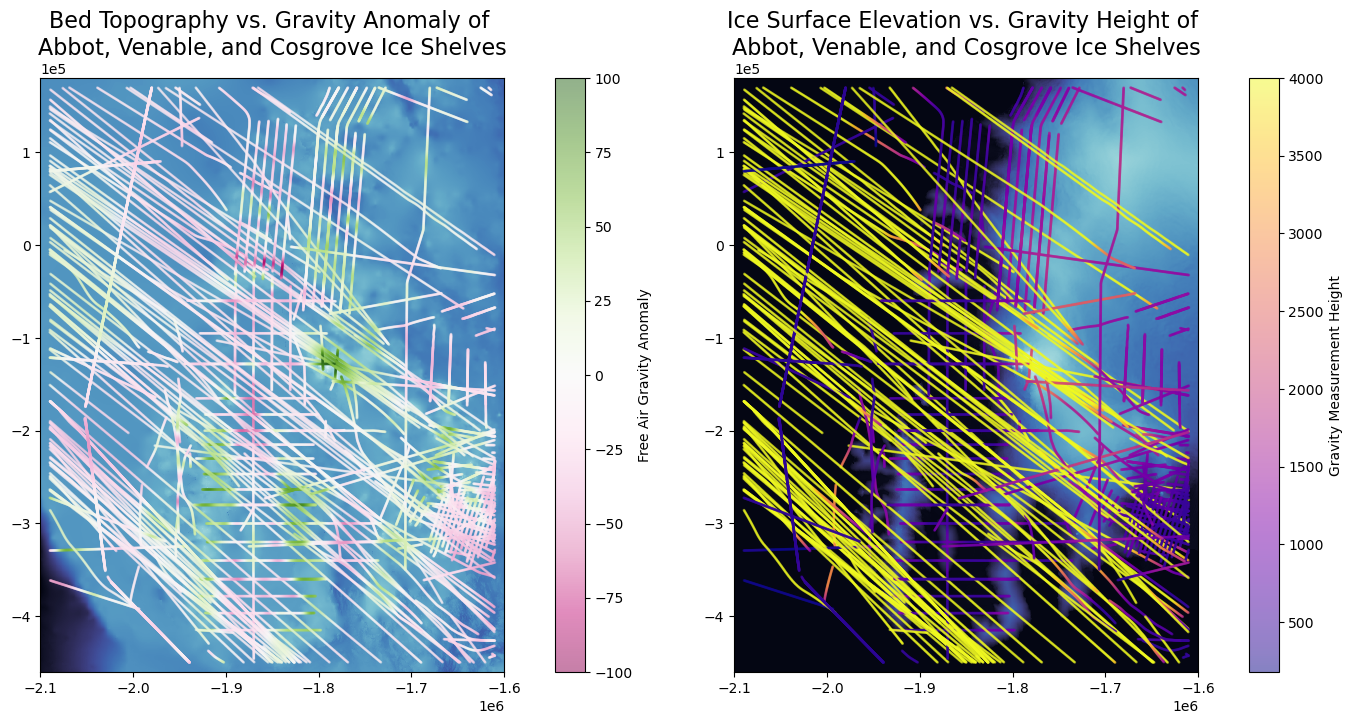

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
plot = ax[0].pcolormesh(ds.x, ds.y, ds.bed, cmap=cmocean.cm.ice)

scatter = ax[0].scatter(grav.x, grav.y, c=grav.faa, s=1, cmap='PiYG', alpha=0.5, vmin=-100, vmax=100)
cbar_faa = plt.colorbar(scatter, location='right', ax=ax[0])
cbar_faa.set_label("Free Air Gravity Anomaly")

ax[0].axis('scaled')
ax[0].set_title("Bed Topography vs. Gravity Anomaly of \nAbbot, Venable, and Cosgrove Ice Shelves", fontsize=16)
ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')

plot = ax[1].pcolormesh(ds.x, ds.y, ds.surface, cmap=cmocean.cm.ice)

scatter = ax[1].scatter(grav.x, grav.y, c=grav.height, s=1, cmap='plasma', alpha=0.5, vmax=4000)
cbar_faa = plt.colorbar(scatter, location='right', ax=ax[1])
cbar_faa.set_label("Gravity Measurement Height")

ax[1].axis('scaled')
ax[1].set_title("Ice Surface Elevation vs. Gravity Height of \nAbbot, Venable, and Cosgrove Ice Shelves", fontsize=16)
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')

plt.tight_layout()
plt.show()

## Terrain Effect

In [ ]:
# upward continue gravity data
def upward_continue(grav, height, ds, maxdist):
    xx, yy = np.meshgrid(ds.x, ds.y)
    pred_coords = (xx, yy, np.full(xx.shape, height))
    grav_tmp = grav[grav.height < height]
    equivalent_sources = hm.EquivalentSourcesGB(damping=1, depth=3000, window_size=20e3)
    coordinates = (grav_tmp.x.values, grav_tmp.y.values, grav_tmp.height.values)
    equivalent_sources.fit(coordinates, grav_tmp.faa.values)
    leveled = equivalent_sources.predict(pred_coords)

    dist_msk = vd.distance_mask(coordinates[:2], maxdist, pred_coords[:2])
    masked = np.where(dist_msk, leveled, np.nan)

    return masked

In [ ]:
height = 4000
maxdist = 4000
grav_uc = upward_continue(grav, height, ds, maxdist)
xx, yy = np.meshgrid(ds.x, ds.y)

# create flattened dataframe of upward continued gravity data
grav_leveled = pd.DataFrame({
    'x': xx.flatten(),
    'y': yy.flatten(),
    'faa': grav_uc.flatten(),
    'height': np.full(grav_uc.flatten().size, height),
    'inv_msk': ds.inv_msk.values.flatten()
})

In [ ]:
# Calculate the terrain effect
terrain_gz = bm_terrain_effect(ds, grav_leveled)
grav_leveled['bouguer'] = grav_leveled['faa'] - terrain_gz

In [ ]:
xx, yy = np.meshgrid(ds.x, ds.y)
inv_pad = vd.distance_mask(
    data_coordinates = (xx[ds.inv_msk==True], yy[ds.inv_msk==True]),
    coordinates = (grav_leveled.x, grav_leveled.y),
    maxdist = 10e3
)

grav_leveled['inv_pad'] = inv_pad
grav_leveled['inv_msk'] = grav_leveled['inv_msk'].replace(0, False).replace(1, True)

# Crop to ice shelf extent
grav_leveled = grav_leveled[(grav_leveled.x >= int(min(ds.x))) & (grav_leveled.x <= int(max(ds.x))) &
        (grav_leveled.y >= int(min(ds.y))) & (grav_leveled.y <= int(max(ds.y)))]

grav_leveled.to_csv(f'processed_data/grav_leveled_{height}.csv', index=False)